# SBATCH环境
一般申请c=8，因为并行两个pool，每个4线程

In [ ]:
#!/bin/bash
#SBATCH -J GTRC-Pool
#SBATCH -p Acluster
#SBATCH -n 1
#SBATCH -c 8
#SBATCH --output=%j.out
#SBATCH --error=%j.err

#set environment
source /Share/samples/Acluster.sh
source /Share/home/dengzg1993/bin/DZG_env.sh

# 全局变量

In [ ]:
WORKDIR=$(pwd)
TMPDIR=/Share/home/dengzg1993/tmp
REF_FASTA=/Data/ChenhaodongLab/Data_deposited/Reference_genome/Physcomitrella/Gd_v6.1/Ppatens_870_V6.fasta
SNP_SITES=/Share/home/dengzg1993/Analyses/DNASeq/Physcomitrella/1.WGS/05.Villersexel/2024.11.25_v6.1/4.annotate/Results/Vx.cohort.snp.final.vcf.gz

# 读取样本

In [ ]:
dos2unix $WORKDIR/sample_pool.tsv

read SAMPLE_MUT READ1_MUT READ2_MUT PLOIDY_MUT < <(awk 'NR==2 {print $1, $2, $3, $4}' $WORKDIR/sample_pool.tsv)
read SAMPLE_WT READ1_WT READ2_WT PLOIDY_WT < <(awk 'NR==3 {print $1, $2, $3, $4}' $WORKDIR/sample_pool.tsv)

# -----------------------------
estimate_depth() {
    local sample_name=$1
    local read1=$2
    local __resultvar=$3   # 传入变量名，用于返回值

    NUM_READS_R1=$(zcat "$read1" | wc -l)
    NUM_READS_R1=$((NUM_READS_R1/4))

    GENOME_SIZE=$(grep -v ">" "$REF_FASTA" | wc -c)
    DEPTH=$(echo "$NUM_READS_R1 * 150 * 2 / $GENOME_SIZE" | bc)
	
    echo "Estimated depth is '$DEPTH' ($sample_name)"
	
    # 返回结果
    eval $__resultvar="'$DEPTH'"
}

estimate_depth "$SAMPLE_MUT" "$READ1_MUT" DEPTH_MUT
estimate_depth "$SAMPLE_WT" "$READ1_WT" DEPTH_WT

mkdir -p $WORKDIR/report $WORKDIR/1.mapping $WORKDIR/2.variants $WORKDIR/3.output
log_step() {
    echo "[$(date '+%Y-%m-%d %H:%M:%S')] $1"
}
log_step "开始任务"


## 例子：
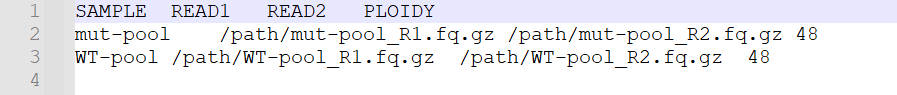

# FastQC

In [ ]:
log_step "执行 FastQC 检查"
fastqc -o $WORKDIR/report --noextract $READ1_MUT $READ2_MUT &> $WORKDIR/report/fastqc_m.log &
fastqc -o $WORKDIR/report --noextract $READ1_WT $READ2_WT &> $WORKDIR/report/fastqc_w.log &
wait

# 映射和去重

In [ ]:
log_step "开始 Reads 映射和去重"
process_sample() {
    local sample_name=$1
    local read1=$2
    local read2=$3

    bwa mem -t 4 -M \
        -R "@RG\tID:$sample_name\tLB:$sample_name\tPL:ILLUMINA\tPM:HISEQ\tSM:$sample_name" \
        $REF_FASTA $read1 $read2 \
        | samtools view -Sb - \
        | samtools sort -o $WORKDIR/1.mapping/$sample_name.sorted.bam

    picard MarkDuplicates \
        -I $WORKDIR/1.mapping/$sample_name.sorted.bam \
        -M $WORKDIR/1.mapping/sorted_dedup_metrics-${sample_name}.txt \
        --TMP_DIR $TMPDIR \
        -O $WORKDIR/1.mapping/$sample_name.sorted_dedup_reads.bam

    samtools index $WORKDIR/1.mapping/$sample_name.sorted_dedup_reads.bam

    FILE_SIZE=$(du -k $WORKDIR/1.mapping/$sample_name.sorted_dedup_reads.bam | awk '{print $1}')
    if [ $FILE_SIZE -ge 1000000 ]; then
        rm $WORKDIR/1.mapping/$sample_name.sorted.bam
    fi
}

process_sample $SAMPLE_MUT $READ1_MUT $READ2_MUT &
process_sample $SAMPLE_WT $READ1_WT $READ2_WT &
wait

# 变异检测

In [ ]:
log_step "执行变异检测"
variant_calling() {
    local sample_name=$1
    local ploidy=$2

    gatk HaplotypeCaller -R $REF_FASTA \
        -I $WORKDIR/1.mapping/$sample_name.sorted_dedup_reads.bam \
        --intervals $SNP_SITES --sample-ploidy $ploidy -ERC GVCF \
        -O $WORKDIR/2.variants/$sample_name.g.vcf.gz
}

variant_calling $SAMPLE_MUT $PLOIDY_MUT &
variant_calling $SAMPLE_WT $PLOIDY_WT &
wait

# 合并变异文件

In [ ]:
log_step "合并变异文件"
gatk CombineGVCFs -R $REF_FASTA \
    --variant $WORKDIR/2.variants/$SAMPLE_MUT.g.vcf.gz \
    --variant $WORKDIR/2.variants/$SAMPLE_WT.g.vcf.gz \
    -O $WORKDIR/2.variants/Combine.g.vcf.gz

gatk GenotypeGVCFs -R $REF_FASTA \
    -V $WORKDIR/2.variants/Combine.g.vcf.gz \
    -O $WORKDIR/3.output/Combine.vcf.gz

mv $WORKDIR/2.variants/Combine.g.vcf.gz.tbi $WORKDIR/3.output/

# 提取等位基因频率

In [ ]:
log_step "提取等位基因频率"
gatk VariantFiltration -R $REF_FASTA \
    -V $WORKDIR/3.output/Combine.vcf.gz \
    -O $WORKDIR/3.output/Combine.filter.vcf.gz \
    -filter-name "hard_filter" \
    -filter "QD < 2.0 || SOR > 3.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0"

gatk SelectVariants --exclude-filtered --select-type-to-include SNP \
    --restrict-alleles-to BIALLELIC \
    -select "vc.getGenotype('$SAMPLE_MUT').getDP() > 0.3 * $DEPTH_MUT" \
    -select "vc.getGenotype('$SAMPLE_MUT').getDP() < 3 * $DEPTH_MUT" \
    -select "vc.getGenotype('$SAMPLE_WT').getDP() > 0.3 * $DEPTH_WT" \
    -select "vc.getGenotype('$SAMPLE_WT').getDP() < 3 * $DEPTH_WT" \
    -V $WORKDIR/3.output/Combine.filter.vcf.gz \
    -O $WORKDIR/3.output/Combine.snp.cleaned.vcf.gz

gatk VariantsToTable -V $WORKDIR/3.output/Combine.snp.cleaned.vcf.gz \
    -F CHROM -F POS -GF AD \
    -O $WORKDIR/3.output/Combine.results_var_AD.table

log_step "任务结束"